# Link prediction for NetworKit

In [1]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt

No module named 'seaborn'


In [2]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


In [3]:
G = readGraph("input/jazz.graph", Format.METIS)

In [4]:
partitionedGraph = linkprediction.RandomEdgePartitioner(G).partitionByPercentage(0.1)
G.numberOfEdges()

2742

In [5]:
partitionedGraph[0].numberOfEdges()

2468

In [6]:
partitionedGraph[1].numberOfEdges()

274

In [7]:
katzIndex = linkprediction.KatzIndex(partitionedGraph[0], 4, 0.5)

In [8]:
dyadScorePairs = katzIndex.runAll()

In [9]:
roc = linkprediction.ROC(partitionedGraph[1], dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()

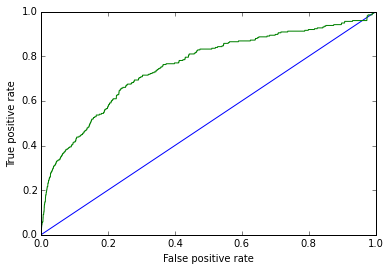

In [10]:
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1])
plt.plot(points[0], points[1])

In [11]:
roc.areaUnderCurve()

0.754086541706825

In [12]:
cn = linkprediction.CommonNeighborsIndex(partitionedGraph[0])

In [13]:
dyadScorePairsCN = cn.runAll()

In [14]:
rocCN = linkprediction.ROC(partitionedGraph[1], dyadScorePairsCN)
rocCN.generatePoints()
pointsCN = rocCN.getPoints()

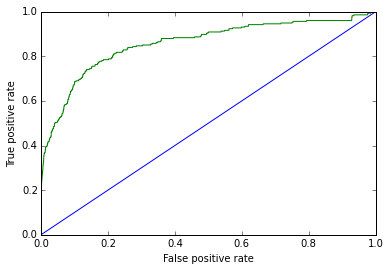

In [15]:
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot([0, 1], [0, 1])
plt.plot(pointsCN[0], pointsCN[1])

In [16]:
rocCN.areaUnderCurve()

0.8571490473409404

In [17]:
node = partitionedGraph[0].randomNode()
nodes = partitionedGraph[0].neighbors(node)

subGraph = graph.Subgraph().fromNodes(partitionedGraph[0], nodes)

In [18]:
LIST_LENGTH = len(nodes) - 1
a = []
color = {}
while len(a) < LIST_LENGTH:
    a.append(500)
for e in nodes:
    color[e] = len(nodes)
a.append(2000)
len(color)
color[list(color)[-1]] = len(nodes) / 2
color[list(color)[-2]] = len(nodes) / 3

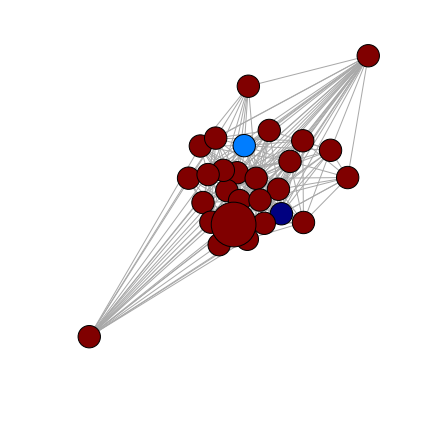

In [19]:
viztasks.drawGraph(subGraph, (7,7), False, a, None, color)

In [24]:
crossValidator = linkprediction.KFoldCrossValidator(G, cn, roc)

In [25]:
crossValidator.crossValidate(10)

0.880815779766855

In [22]:
crossValidator = linkprediction.KFoldCrossValidator(G, katzIndex, roc)

In [23]:
crossValidator.crossValidate(10)

0.7677863584084944